## Analyze A/B Test Results

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.
 
<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
import statsmodels.api as sm

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df[df['converted']==1].shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()
# No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Store your new dataframe in **df2**.

In [8]:
df2 = df [((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True] 
df2 = df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == True] 

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions 

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it? 

c. What is the row information for the repeat **user_id**? 

In [11]:
hb2 = df2[df2['user_id'].duplicated()] ; hb2

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop(hb2.index, inplace=True) 

In [13]:
df2.nunique()
# removed sucessfully 

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

e. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2[df2['converted']==1].shape[0] / df2.shape[0]

0.11959708724499628

f. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control" ')['converted'].value_counts()[1]/ sum(df2.query('group == "control" ')['converted'].value_counts()[0:2])

0.1203863045004612

g. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment" ')['converted'].value_counts()[1]/ sum(df2.query('group == "treatment" ')['converted'].value_counts()[0:2])

0.11880806551510564

h. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page" ').shape[0] / df2.shape[0]

0.5000619442226688

I. Consider your results and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

As we found in the Part1 that **new treatment page(0.12 = 12%) show higher probability than new control page(0.118 ==11.8%).** Therefore we can say that there is sufficient evidence to conculde that the new treatment page leads to more conversions

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old}  - p_{new} \geq 0$$


$$H_1: p_{old}  - p_{new}  < 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [53]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [54]:
p_old = p_new 
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [55]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [56]:
n_old = df2.query('group == "control"').shape[0] 
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [57]:
test_new = np.random.binomial(1,p_new,n_new)
new_page_converted = (test_new==1).mean() 
new_page_converted

0.1203289518959466

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [58]:
test_old = np.random.binomial(1,p_old,n_old)
old_page_converted = (test_old==1).mean() 
old_page_converted

0.12140506904194832

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [59]:
new_page_converted-old_page_converted
#nearly zero

-0.001076117146001726

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [60]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

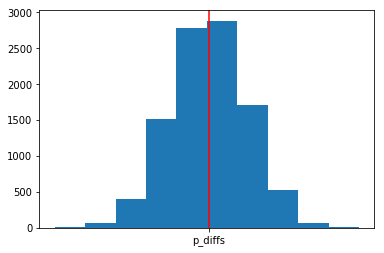

In [61]:
plt.hist(p_diffs)
plt.axvline(x='p_diffs',color='red')
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [62]:
obs_mean = df2.query('group=="treatment"')['converted'].mean() - df2.query('group=="control"')['converted'].mean() 
(p_diffs >obs_mean ).mean()

0.9085

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This value is called **P-Value** in scientific studies. 

**Meaning of P-Value**
- If null hypothesis is true, the probability of obtaining the observed statistic of one more extremen in favor of the alternative hypothesis. 

$$ p_{value} = 0.90  \geq 0.05$$


Throughout we can guess that this value is statistiacally insignificant. Besides we have large p-value which mean we should take null hypothesis

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [63]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].value_counts()[1]
convert_new = df2.query('group == "treatment"')['converted'].value_counts()[1]
n_old =   df2.query('group == "control"').shape[0]
n_new =  df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [64]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger') 
# according to the documentation of  ztest alternative='larger' means 
#The alternative hypothesis can be either two-sided or one of the one- sided tests with "prop > value". 
# prop is proportion of two sample. in this case  p_diffs 
# value is obs_mean 
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Throughout we found  P-Value and Z-score.
Z-score mean tells you how many standard deviations from the mean your score is.

$$ z_{score} = \frac {(x- \mu)}{\sigma}$$

So we got
$$ p_{value} = 0.90  \geq 0.05$$

$$ z_{score} = -1.311$$
**So P-value in each test shows same value(0.90)**


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression** 

$$H_0: p_{old}  - p_{new} = 0$$


$$H_1: p_{old}  - p_{new} \neq 0$$


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [65]:
df2_new = df2.copy()
# copy the df2 dataset

In [66]:
df2_new['intercept'] = 1 
df2_new['ab_page'] = pd.get_dummies(df2_new['group'])['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [67]:
lm = sm.Logit(df2_new['converted'],df2_new[['intercept','ab_page']])
result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [69]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:34:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

p-value of **ab_page** is 0.190.  In **Part II** we compare the difference of p_new and p_old. But in **Part III** we build multiple regression. That means we change type of dummy variable from categorical to qunatative data. Furthermore we are focusing on the error of each data with regression line. The result says that is still not statistically insignificant but closer to 5% which mean p_new is closer to p_old 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding more factors into the regression model brings higher accuracy of model. In case we have to make more columns to add into the regression model like for example **Interactions term or Higher order term** 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [70]:
df2_countries = df2_new.copy()
#copy the df2_new dataset  

In [71]:
countries = pd.read_csv('countries.csv')  
# load the countries.csv

In [72]:
df2_countries=df2_countries.set_index('user_id').join(countries.set_index('user_id'))
#merge df2_countires and with countries on the appropriate rows

In [73]:
country_dummies = pd.get_dummies(df2_countries['country'])
df2_countries=df2_countries.join(country_dummies)
# joining the table with dummy variables 

In [74]:
df2_countries.head()
# 5 rows of df2_countries dataset

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [75]:
lm_CA = sm.Logit(df2_countries['converted'],df2_countries[['intercept','CA']])
# US as a baseline
result_CA = lm_CA.fit()
result_CA.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               1.259e-05
Time:                        23:35:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1016
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9941      0.006   -340.272      0.000      -2.006      -1.983
CA            -0.0434      0.027     -1.629      0.103      -0.096       0.009
==============================================================================
"""

In [76]:
lm_UK = sm.Logit(df2_countries['converted'],df2_countries[['intercept','UK']])
# US as a baseline
result_UK = lm_UK.fit()
result_UK.summary()

Optimization terminated successfully.
         Current function value: 0.366120
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               4.280e-06
Time:                        23:35:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3399
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9994      0.007   -302.640      0.000      -2.012      -1.986
UK             0.0126      0.013      0.955      0.340      -0.013       0.038
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [77]:
df2_interaction = df2_countries.copy()
# copy the df2 countries dataset

In [78]:
df2_interaction['page_countryCA'] = df2_interaction['ab_page'] * df2_interaction['CA']  
df2_interaction['page_countryUK'] = df2_interaction['ab_page'] * df2_interaction['UK']  
df2_interaction['page_countryUS'] = df2_interaction['ab_page'] * df2_interaction['US']  
# Interact two factors which are ab_page and CA/UK/US to find out which factor is most different depending on the ab_page
df2_interaction.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,page_countryCA,page_countryUK,page_countryUS
user_id,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [79]:
lm_interactionCA = sm.Logit(df2_interaction['converted'],df2_interaction[['intercept','page_countryCA']])
# relation with CA
result_interactionCA = lm_interactionCA.fit()
result_interactionCA.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               2.016e-05
Time:                        23:35:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.03834
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9944      0.006   -344.689      0.000      -2.006      -1.983
page_countryCA    -0.0771      0.038     -2.052      0.040      -0.151      -0.003
==================================================================================
"""

In [80]:
lm_interactionUK = sm.Logit(df2_interaction['converted'],df2_interaction[['intercept','page_countryUK']])
# relation with UK
result_interactionUK = lm_interactionUK.fit()
result_interactionUK.summary()

Optimization terminated successfully.
         Current function value: 0.366120
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               4.544e-06
Time:                        23:35:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3255
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9984      0.006   -326.853      0.000      -2.010      -1.986
page_countryUK     0.0170      0.017      0.985      0.325      -0.017       0.051
==================================================================================
"""

In [81]:
lm_interactionUS = sm.Logit(df2_interaction['converted'],df2_interaction[['intercept','page_countryUS']])
# relation with US
result_interactionUS = lm_interactionUS.fit()
result_interactionUS.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:               8.979e-06
Time:                        23:35:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1669
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9905      0.007   -281.174      0.000      -2.004      -1.977
page_countryUS    -0.0166      0.012     -1.381      0.167      -0.040       0.007
==================================================================================
"""

## Conclusion




#### Regression  of each columns

1. column: intercept & ab_page
   - Prerequisite : categorical datatype should be changed into qunatative datatype (dummy variable)
   - P-value: 0.190
   - Interpretation: 0.190 is larger than 0.05 -> statistically insignificant 


2. column: intercept & countries (CA)
   - Prerequisite:  US as as baseline, categorical datatype should be changed into qunatative datatype (dummy variable)
   - P-value: 0.103
   - Interpretation: 0.103 is larger than 0.05 -> statistically insignificant but closer to boundary than column with ab_page 


3. column: intercept & countries (UK)
   - Prerequisite:  US as as baseline, categorical datatype should be changed into qunatative datatype (dummy variable)
   - P-value: 0.340
   - Interpretation: 0.103 is larger than 0.05 -> statistically insignificant and worst result of all experiments which have done already



4. Interaction : intercept & page_countryCA
   - Prerequisite : page_countryUS = column data of ab_page multiplies with CA
   - P-value : 0.04
   - Interpretation: 0.04 is smaller than 0.50 -> statistically significant and best result of all experiments which have done already



5. Interaction : intercept & page_countryUK
   - Prerequisite : page_countryUS = column data of ab_page multiplies with UK
   - P-value : 0.325
   - Interpretation:  0.325 is larger than 0.05 -> statistically insignificant 


6. Interaction : intercept & page_countryUS
   - Prerequisite : page_countryUS = column data of ab_page multiplies with US
   - P-value : 0.167
   - Interpretation:  0.167 is larger than 0.05 -> statistically insignificant  but closer to boundary than column with page_countryUK
    
**we can found out that dependence of each country with ab_page is following**

$$ CA \geq US \geq UK $$

    